In [1]:
import pandas as pd
import datetime as datetime
import numpy as np
import matplotlib.pyplot as plt
import patsy
import seaborn as sns
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
#open from pickled file
#try again after second crawl finishes
movie_df=pd.read_pickle('movie_data.pkl')
movie2_df=pd.read_pickle('movie_data2.pkl')
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
Name             3000 non-null object
UserRating       3000 non-null object
Budget           3000 non-null object
Genres           2982 non-null object
ReleaseDate      2918 non-null object
Runtime          2554 non-null object
Directors        2982 non-null object
Writers          2977 non-null object
Stars            2977 non-null object
ContentRating    2977 non-null object
ProductionCo     2977 non-null object
dtypes: object(11)
memory usage: 257.9+ KB


In [3]:
movie_df=movie_df.drop_duplicates('Name')

In [4]:
cont_features=['UserRating','Budget','Runtime','ReleaseDelta']
single_cat_features=['ContentRating']
multiple_cat_features=['Genres','Directors','Writers','Stars','ProductionCo']

In [5]:
movie_df['Runtime']=movie_df['Runtime'].astype(float)
movie_df['UserRating']=movie_df['UserRating'].astype(float)

#convert budget to float
def conv_budget(x):
    try:
        f=float(x)
        return f
    except:
        return 0.0
movie_df['Budget']=movie_df['Budget'].apply(conv_budget)

In [6]:
movie_df['ReleaseDateTime']=pd.to_datetime(movie_df['ReleaseDate'])
movie_df['ReleaseDelta']=(movie_df['ReleaseDateTime']-movie_df['ReleaseDateTime'].min())/np.timedelta64(1,'D')
movie_df.ReleaseDelta.head()

0    32961.0
1    36069.0
2    32771.0
3    31176.0
4    17698.0
Name: ReleaseDelta, dtype: float64

In [7]:
temp_df=movie_df.dropna()
#remove na elements

In [8]:
#clean categorical data

In [9]:
for feat in multiple_cat_features:
    movie_df[feat]=movie_df[feat].astype(list)

In [10]:
#below row returns index of any movie that has a nan element
#pd.isnull(movie_df).any(1).nonzero()[0]

In [11]:
# transform oodles of categorical data into proper columns
# pats is fine for single categories, but for multiples see below
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.get_dummies.html

In [12]:
#transform things with single category
for feat in single_cat_features:
    X=patsy.dmatrix(feat,data=temp_df,return_type='dataframe')
    temp_df=temp_df.join(X)

In [13]:
#transform things with multiple categories
for feat in multiple_cat_features:
    X=temp_df[feat].apply('*'.join).str.get_dummies('*').add_prefix(feat+': ')
    temp_df=pd.concat([temp_df,X],axis=1)

In [14]:
#drop original columns to eliminate strings and lists from dataframe
temp_df.drop([col for col in multiple_cat_features],axis=1,inplace=True)
temp_df.drop([col for col in single_cat_features],axis=1,inplace=True)

In [15]:
multiple_cat_features

['Genres', 'Directors', 'Writers', 'Stars', 'ProductionCo']

In [16]:
#define cutoff limits for categories that have multiple features
cutoff_amt={'Genres':6,
            'Directors':5,
            'Writers':5,
            'Stars':7,
            'ProductionCo':9
}
cutoff_amt

In [17]:
#drops multiple_cat features which appear in a small numer of movies
#optimize number of people on per-category basis
#LONG RUNTIME
for feat in multiple_cat_features:
    feat_arr=[col for col in temp_df.columns if feat in col]
    cut = cutoff_amt[feat]
    for col in feat_arr:
        if temp_df[col].sum()<cut:
            temp_df.drop([col],axis=1,inplace=True)

In [18]:
#check number of notable people per category left
for feat in multiple_cat_features:
    print(feat,len([col for col in temp_df.columns if feat in col]))

Genres 22
Directors 53
Writers 65
Stars 100
ProductionCo 57


In [19]:
temp_df.drop(['ReleaseDate'],axis=1,inplace=True)
temp_df.drop(['ReleaseDateTime'],axis=1,inplace=True)

In [20]:
#number of features remaining 
len(temp_df.columns)

316

In [21]:
plot_df=temp_df

In [22]:
plot_df.to_pickle('encoded_movie_df.pkl')

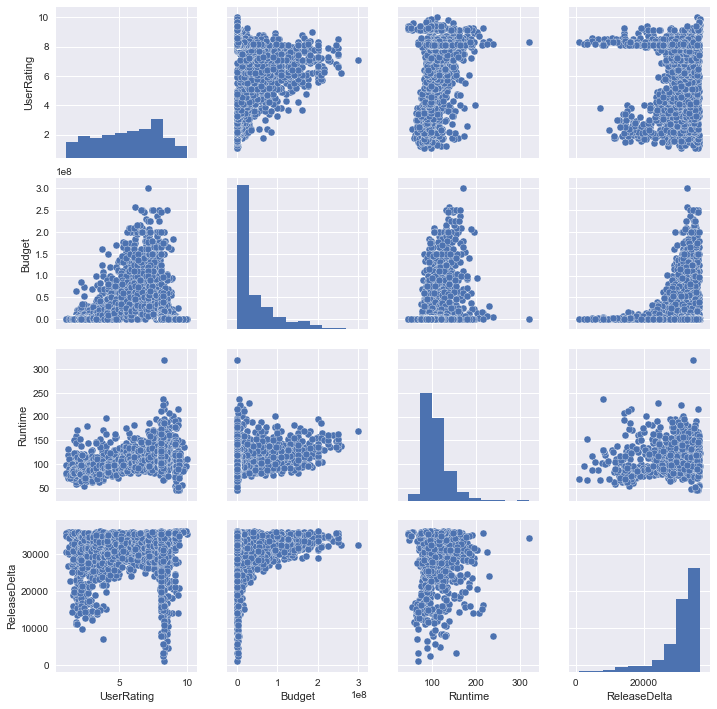

In [23]:
sns.pairplot(plot_df[cont_features])

In [24]:
#view pairplots - might be hard w/so much categorical data

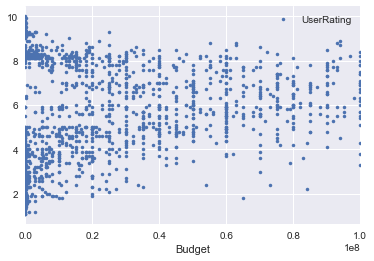

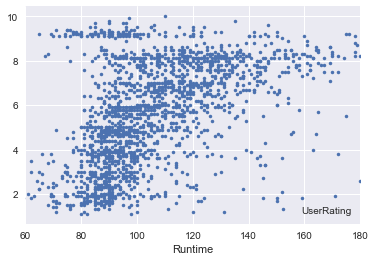

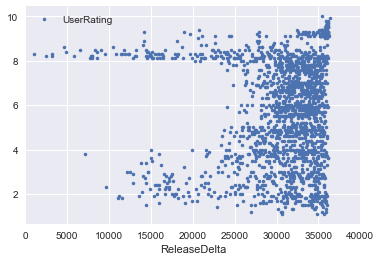

In [25]:
plot_df.plot(x='Budget',y='UserRating',style='.',xlim=(0,1e8))
plot_df.plot(x='Runtime',y='UserRating',style='.',xlim=(60,180))
plot_df.plot(x='ReleaseDelta',y='UserRating',style='.',xlim=(0,40000))

In [26]:
#PIPELINE TIME
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold

/Users/gpatient/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [27]:
plot_features = multiple_cat_features+single_cat_features+cont_features
X = plot_df.iloc[:,2:]
y = plot_df['UserRating']

In [28]:
pipeline = [
    #('imputer', Imputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(1)),
    ('scale2',StandardScaler()),
    #('scale2', MinMaxScaler()), 
    ('estimator', Ridge())
]

pipeline = Pipeline(pipeline)

In [29]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor

# pipeline = [
#     #('imputer', Imputer(strategy='mean')),
#     ('scaler', StandardScaler()),
#     ('poly', PolynomialFeatures(1)),
#     ('scale2',StandardScaler()),
#     #('scale2', MinMaxScaler()), 
#     ('estimator', GradientBoostingRegressor())
# ]

# pipeline = Pipeline(pipeline)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)

In [30]:
# s = StandardScaler()

# #X_new = s.fit_transform(i.fit_transform(X))

# X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=.2)

# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

(array([   4.,    5.,   30.,   60.,  111.,   96.,   45.,   23.,   10.,    2.]),
 array([-5.57383715, -4.43503595, -3.29623475, -2.15743355, -1.01863235,
         0.12016886,  1.25897006,  2.39777126,  3.53657246,  4.67537366,
         5.81417486]),
 <a list of 10 Patch objects>)

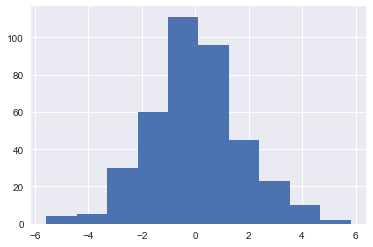

In [56]:
res=y_pred-y_test
plt.hist(res)

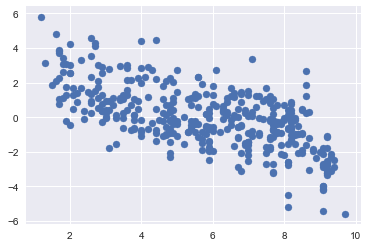

In [57]:
plt.scatter(y_test,res)

In [58]:
# p=plt.scatter(y_test,y_pred)
# p.axes.set_xlim(1,10)
# p.axes.set_ylim(1,10)

(1, 10)

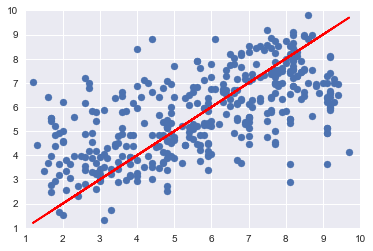

In [59]:
fig, ax = plt.subplots()
fit = np.polyfit(y_test,y_pred,1)
ax.plot(y_test,y_test,color='red')

ax.scatter(y_test,y_pred)
ax.axes.set_xlim(1,10)
ax.axes.set_ylim(1,10)

In [73]:
r2=pipeline.score(X_test,y_test)
adj_r2=1-((1-r2**2)*(len(y_train)-1))/(len(y_train)-312-1)
print(r2,adj_r2)

0.36225108292 -0.0891461331768


0.515128524802
0.541555876454 2.30160614394


/Users/gpatient/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


stasmodels result: 0.497906975314 0.37962544546


(1, 10)

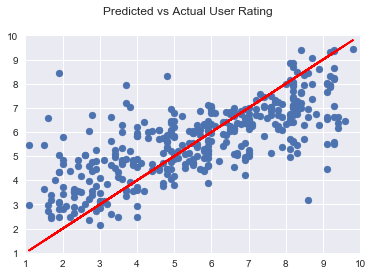

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

pipeline = [
    ('scaler', StandardScaler()),
    ('estimator', RandomForestRegressor())
]
pipeline = Pipeline(pipeline)
pipeline.fit(X_train,y_train)
r2_randfor=pipeline.score(X_test,y_test)
print(r2_randfor)

pipeline = [
    ('scaler', StandardScaler()),
    ('estimator', GradientBoostingRegressor())
]
pipeline = Pipeline(pipeline)
pipeline.fit(X_train,y_train)
r2_gradboost=pipeline.score(X_test,y_test)
y_pred=pipeline.predict(X_test)
print(r2_gradboost, mean_squared_error(y_test,y_pred))

import statsmodels.api as sm
X1 = sm.add_constant(X_train)
result = sm.OLS(y_train, X1).fit()
#print dir(result)
print ('stasmodels result:',result.rsquared, result.rsquared_adj)

fig, ax = plt.subplots()
ax.plot(y_test,y_test,color='red')

fig.suptitle('Predicted vs Actual User Rating')
ax.scatter(y_test,y_pred)
ax.axes.set_xlim(1,10)
ax.axes.set_ylim(1,10)

In [38]:
#drop features deemed to be useless after analysis
#drop_features=list()
drop_features=['ReleaseDelta','Budget']
final_df=plot_df
for feat in drop_features:
    final_df.drop([feat],axis=1,inplace=True)

In [39]:
#Again but without the useless junk
X = plot_df.iloc[:,2:]
y = plot_df['UserRating']

In [40]:
plot_features = multiple_cat_features+single_cat_features+cont_features
X = plot_df.iloc[:,2:]
y = plot_df['UserRating']

pipeline = [
    ('prescaler', StandardScaler()),
    ('poly', PolynomialFeatures(1)),
    ('postscaler',StandardScaler()),
    ('estimator', Ridge())
]

pipeline = Pipeline(pipeline)

(array([  5.,  31.,  46.,  81.,  80.,  75.,  36.,  22.,   6.,   4.]),
 array([-4.53985938, -3.49733347, -2.45480756, -1.41228165, -0.36975574,
         0.67277017,  1.71529607,  2.75782198,  3.80034789,  4.8428738 ,
         5.88539971]),
 <a list of 10 Patch objects>)

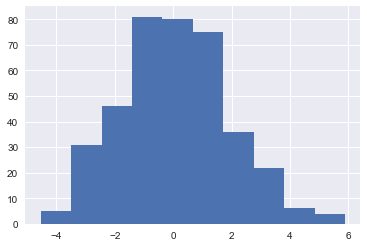

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

res=y_pred-y_test
plt.hist(res)

In [47]:
import statsmodels.api as sm
X1 = sm.add_constant(X_train)
result = sm.OLS(y_train, X1).fit()
#print dir(result)
print ('stasmodels result:',result.rsquared, result.rsquared_adj)

stasmodels result: 0.477436363041 0.355365497448


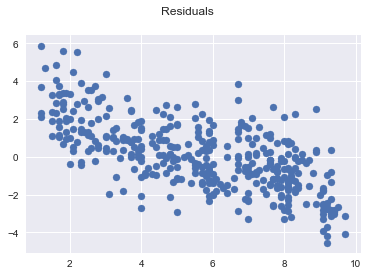

In [42]:
plt.scatter(y_test,res)
plt.suptitle('Residuals')

0.36225108292 3.16131653665


0.36225108292025821

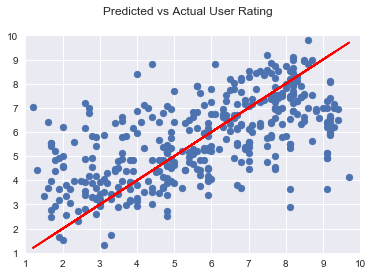

In [76]:
from sklearn.metrics import r2_score
fig, ax = plt.subplots()
ax.plot(y_test,y_test,color='red')

fig.suptitle('Predicted vs Actual User Rating')
ax.scatter(y_test,y_pred)
ax.axes.set_xlim(1,10)
ax.axes.set_ylim(1,10)
print(r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred))
pipeline.score(X_test,y_test)

In [95]:
pipeline.steps[3][1].coef_

array([  0.00000000e+00,   4.31845518e-01,   0.00000000e+00,
        -5.97230830e-02,  -3.96819376e-02,  -5.61631974e-02,
         1.09650690e-01,  -1.07315327e-01,  -5.35511402e-02,
        -1.20356866e-02,   7.18540252e-02,   2.95079355e-02,
         2.59041577e-02,  -3.61006918e-02,  -3.76683028e-02,
         0.00000000e+00,  -3.25085216e-01,   1.57056397e-02,
         2.42757810e-01,   1.73485187e-01,  -1.49397708e-01,
        -4.83044588e-02,   7.06794196e-01,  -1.34575758e-01,
        -7.24707822e-02,   1.05610097e-01,  -1.45636283e-01,
        -4.51544481e-01,   1.22234039e-02,   6.23433084e-02,
         1.73175899e-01,  -1.41751018e-01,  -1.04590712e-01,
        -8.52585982e-02,   2.16870749e-02,   7.20795094e-02,
         1.45983575e-02,  -2.12405404e-02,  -3.48932824e-02,
        -3.18094196e-02,   8.97814982e-02,   4.79072989e-02,
         7.21926145e-03,  -3.88189770e-02,  -2.03370185e-02,
         8.35097645e-02,   7.10893451e-02,   2.25949740e-01,
         1.01317874e-02,

In [89]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1929 entries, 0 to 2249
Columns: 314 entries, Name to ProductionCo: Working Title Films
dtypes: float64(16), int64(297), object(1)
memory usage: 4.7+ MB


In [45]:
final_df.UserRating.mean()

5.676412649040989

In [46]:
cheap_mean = 5.676412649040989